# Создание OCR модели для распознавания данных на номерном знаке

In [ ]:
import os
import glob
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
from Levenshtein import distance as levenshtein_distance




print("--- Проверка системы ---")
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_name = torch.cuda.get_device_name(0)
    print(f"✅ CUDA доступна. Будет использован GPU: {gpu_name}")
else:
    device = torch.device("cpu")
    print("⚠️ CUDA не найдена. Обучение будет происходить на CPU.")
print("---------------------\n")

--- Проверка системы ---
✅ CUDA доступна. Будет использован GPU: NVIDIA GeForce RTX 3070 Ti
---------------------



In [2]:
# --- Конфигурация данных ---
DATASET_BASE_PATH = 'E:/Datasets/numberplate/autoriaNumberplateOcrRu-2021-09-01/' 
TRAIN_DIR = os.path.join(DATASET_BASE_PATH, 'train')
VAL_DIR = os.path.join(DATASET_BASE_PATH, 'val')

# --- Сбор алфавита ---
all_chars = set()
print("Собираю алфавит из обучающей выборки...")

train_ann_dir = os.path.join(TRAIN_DIR, 'ann')
train_files = glob.glob(os.path.join(train_ann_dir, '*.json'))

for ann_path in tqdm(train_files):
    with open(ann_path, 'r', encoding='utf-8') as f:
        ann = json.load(f)
        # В этом датасете текст номера лежит в поле 'description'
        plate_text = ann.get('description', '')
        for char in plate_text:
            all_chars.add(char)

# --- Создание словарей и констант ---
alphabet = sorted(list(all_chars))
ALPHABET = ''.join(alphabet)
print(f"✅ Алфавит собран: '{ALPHABET}' (Длина: {len(ALPHABET)})")

# +1 для 'blank' токена CTC
NUM_CLASSES = len(ALPHABET) + 1 
IMG_HEIGHT = 32
IMG_WIDTH = 128
BATCH_SIZE = 64

# --- Словари для кодирования/декодирования ---
char_to_int = {char: i + 1 for i, char in enumerate(ALPHABET)}
int_to_char = {i: char for char, i in char_to_int.items()}

Собираю алфавит из обучающей выборки...


  0%|          | 0/49382 [00:00<?, ?it/s]

✅ Алфавит собран: '0123456789ABCEHKMOPTXY' (Длина: 22)


In [3]:
class OCRDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.img_dir = os.path.join(base_dir, 'img')
        self.ann_dir = os.path.join(base_dir, 'ann')
        self.transform = transform
        self.filenames = [os.path.splitext(f)[0] for f in os.listdir(self.img_dir)]
        print(f"Найдено {len(self.filenames)} изображений в {base_dir}")

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        img_path = os.path.join(self.img_dir, filename + '.png') 
        ann_path = os.path.join(self.ann_dir, filename + '.json')
        
        try:
            image = Image.open(img_path).convert('L')
            with open(ann_path, 'r', encoding='utf-8') as f:
                ann = json.load(f)
                text = ann.get('description', '')
            if self.transform:
                image = self.transform(image)
            return image, text
        except FileNotFoundError:
            return self.__getitem__((idx + 1) % len(self))

transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = OCRDataset(TRAIN_DIR, transform=transform)
val_dataset = OCRDataset(VAL_DIR, transform=transform)

def collate_fn(batch):
    images, texts = zip(*batch)
    images = torch.stack(images, 0)
    encoded_texts = [torch.tensor([char_to_int.get(char, 0) for char in text]) for text in texts]
    text_lengths = torch.tensor([len(text) for text in encoded_texts])
    encoded_texts = nn.utils.rnn.pad_sequence(encoded_texts, batch_first=True)
    return images, encoded_texts, text_lengths

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=False)

print("\n✅ Даталоадеры готовы.")

Найдено 49382 изображений в E:/Datasets/numberplate/autoriaNumberplateOcrRu-2021-09-01/train
Найдено 4893 изображений в E:/Datasets/numberplate/autoriaNumberplateOcrRu-2021-09-01/val

✅ Даталоадеры готовы.


In [ ]:
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()
        
        # --- CNN часть (Глаза) ---
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), 
            nn.ReLU(True), 
            nn.MaxPool2d(2, 2), # -> height: 16
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), 
            nn.ReLU(True), 
            nn.MaxPool2d(2, 2), # -> height: 8
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256), 
            nn.ReLU(True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1), 
            nn.ReLU(True), 
            nn.MaxPool2d((2, 1), (2, 1)), # -> height: 4
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512), 
            nn.ReLU(True),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1), 
            nn.ReLU(True), 
            nn.MaxPool2d((2, 1), (2, 1)) # -> height: 2. 
        
        # --- RNN часть (Мозг) ---
        
        self.rnn = nn.LSTM(512 * 2, 256, bidirectional=True, num_layers=2, batch_first=True)
        
        # --- Classifier (Рот) ---
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        # Прогоняем через CNN
        x = self.cnn(x) # -> (batch, 512, 2, 32)
        
        
        # "Распрямляем" выход CNN для подачи в RNN
        # объединяем каналы и высоту
        batch, channels, height, width = x.size()
        x = x.reshape(batch, channels * height, width) 
        
        # Меняем оси местами для RNN, который ожидает (batch, seq_len, features)
        x = x.permute(0, 2, 1) # -> (batch, 32, 1024)
        
        # Прогоняем через RNN
        x, _ = self.rnn(x) # -> (batch, 32, 512)
        
        # Прогоняем через классификатор
        x = self.classifier(x) # -> (batch, 32, num_classes)
        
        # Для CTCLoss нам нужен формат (sequence_length, batch, num_classes)
        x = x.permute(1, 0, 2) # -> (32, batch, num_classes)
        x = nn.functional.log_softmax(x, dim=2)
        
        return x

print("Архитектура модели CRNN.")

Архитектура модели CRNN.


In [5]:
model = CRNN(NUM_CLASSES).to(device)
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def decode_preds(preds):
    preds = preds.permute(1, 0, 2)
    preds = torch.argmax(preds, dim=2)
    decoded_texts = []
    for pred in preds:
        decoded_seq = []
        last_char_idx = 0
        for char_idx in pred:
            char_idx = char_idx.item()
            if char_idx != 0 and char_idx != last_char_idx:
                decoded_seq.append(int_to_char.get(char_idx, ''))
            last_char_idx = char_idx
        decoded_texts.append("".join(decoded_seq))
    return decoded_texts

def calculate_cer(preds, targets):
    total_dist, total_len = 0, 0
    for pred, target in zip(preds, targets):
        total_dist += levenshtein_distance(pred, target)
        total_len += len(target)
    return total_dist / total_len if total_len > 0 else 0

history = {'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'val_cer': []}
best_val_accuracy = 0.0
NUM_EPOCHS = 30

print(f"\n🚀 Начинаю обучение на {NUM_EPOCHS} эпох...")

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for images, texts, text_lengths in progress_bar:
        images, texts, text_lengths = images.to(device), texts.to(device), text_lengths.to(device)
        optimizer.zero_grad()
        preds = model(images)
        pred_lengths = torch.full(size=(images.size(0),), fill_value=preds.size(0), dtype=torch.long, device=device)
        loss = criterion(preds, texts, pred_lengths, text_lengths)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    
    model.eval()
    val_loss = 0
    all_decoded_preds, all_original_texts = [], []
    with torch.no_grad():
        progress_bar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
        for images, texts, text_lengths in progress_bar_val:
            images, texts, text_lengths = images.to(device), texts.to(device), text_lengths.to(device)
            preds = model(images)
            pred_lengths = torch.full(size=(images.size(0),), fill_value=preds.size(0), dtype=torch.long, device=device)
            val_loss += criterion(preds, texts, pred_lengths, text_lengths).item()
            decoded_preds = decode_preds(preds)
            original_texts = ["".join([int_to_char.get(i.item(), '') for i in text if i != 0]) for text in texts]
            all_decoded_preds.extend(decoded_preds)
            all_original_texts.extend(original_texts)
            
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = sum(1 for pred, orig in zip(all_decoded_preds, all_original_texts) if pred == orig) / len(all_original_texts)
    val_cer = calculate_cer(all_decoded_preds, all_original_texts)
    
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_accuracy)
    history['val_cer'].append(val_cer)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f} | Val CER: {val_cer:.4f}")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'crnn_ocr_model_best.pth')
        print(f"✨ Новая лучшая модель сохранена с точностью: {best_val_accuracy:.4f}")



🚀 Начинаю обучение на 30 эпох...


Epoch 1/30 [Train]:   0%|          | 0/772 [00:00<?, ?it/s]

Epoch 1/30 [Val]:   0%|          | 0/77 [00:00<?, ?it/s]

Epoch 1/30 | Train Loss: 2.7078 | Val Loss: 1.4953 | Val Acc: 0.0006 | Val CER: 0.5545
✨ Новая лучшая модель сохранена с точностью: 0.0006


Epoch 2/30 [Train]:   0%|          | 0/772 [00:00<?, ?it/s]

Epoch 2/30 [Val]:   0%|          | 0/77 [00:00<?, ?it/s]

Epoch 2/30 | Train Loss: 0.2753 | Val Loss: 0.0276 | Val Acc: 0.9618 | Val CER: 0.0050
✨ Новая лучшая модель сохранена с точностью: 0.9618


Epoch 3/30 [Train]:   0%|          | 0/772 [00:00<?, ?it/s]

Epoch 3/30 [Val]:   0%|          | 0/77 [00:00<?, ?it/s]

Epoch 3/30 | Train Loss: 0.0210 | Val Loss: 0.0108 | Val Acc: 0.9869 | Val CER: 0.0017
✨ Новая лучшая модель сохранена с точностью: 0.9869


Epoch 4/30 [Train]:   0%|          | 0/772 [00:00<?, ?it/s]

Epoch 4/30 [Val]:   0%|          | 0/77 [00:00<?, ?it/s]

Epoch 4/30 | Train Loss: 0.0129 | Val Loss: 0.0139 | Val Acc: 0.9777 | Val CER: 0.0028


Epoch 5/30 [Train]:   0%|          | 0/772 [00:00<?, ?it/s]

Epoch 5/30 [Val]:   0%|          | 0/77 [00:00<?, ?it/s]

Epoch 5/30 | Train Loss: 0.0091 | Val Loss: 0.0066 | Val Acc: 0.9896 | Val CER: 0.0013
✨ Новая лучшая модель сохранена с точностью: 0.9896


Epoch 6/30 [Train]:   0%|          | 0/772 [00:00<?, ?it/s]

Epoch 6/30 [Val]:   0%|          | 0/77 [00:00<?, ?it/s]

Epoch 6/30 | Train Loss: 0.0057 | Val Loss: 0.0077 | Val Acc: 0.9855 | Val CER: 0.0020


Epoch 7/30 [Train]:   0%|          | 0/772 [00:00<?, ?it/s]

Epoch 7/30 [Val]:   0%|          | 0/77 [00:00<?, ?it/s]

Epoch 7/30 | Train Loss: 0.0082 | Val Loss: 0.0060 | Val Acc: 0.9910 | Val CER: 0.0011
✨ Новая лучшая модель сохранена с точностью: 0.9910


Epoch 8/30 [Train]:   0%|          | 0/772 [00:00<?, ?it/s]

Epoch 8/30 [Val]:   0%|          | 0/77 [00:00<?, ?it/s]

Epoch 8/30 | Train Loss: 0.0054 | Val Loss: 0.0048 | Val Acc: 0.9933 | Val CER: 0.0008
✨ Новая лучшая модель сохранена с точностью: 0.9933


Epoch 9/30 [Train]:   0%|          | 0/772 [00:00<?, ?it/s]

KeyboardInterrupt: 

--- 📊 Графики процесса обучения ---


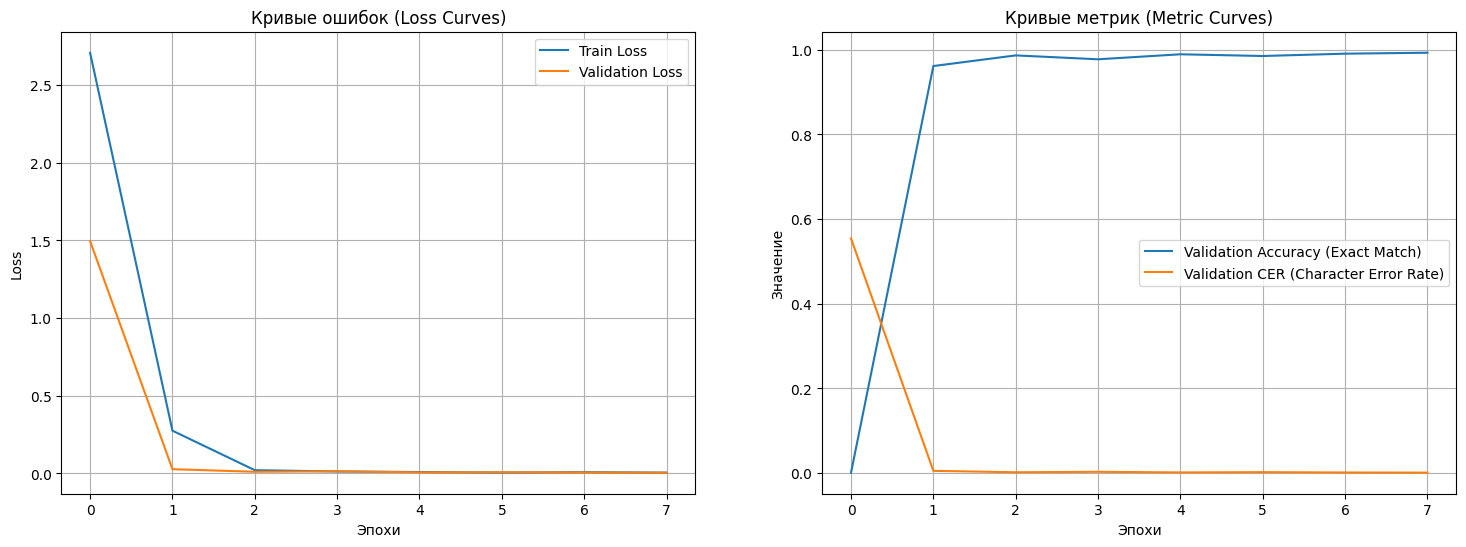


---  Confusion Matrix (на уровне символов) ---


Сбор данных для матрицы ошибок:   0%|          | 0/77 [00:00<?, ?it/s]

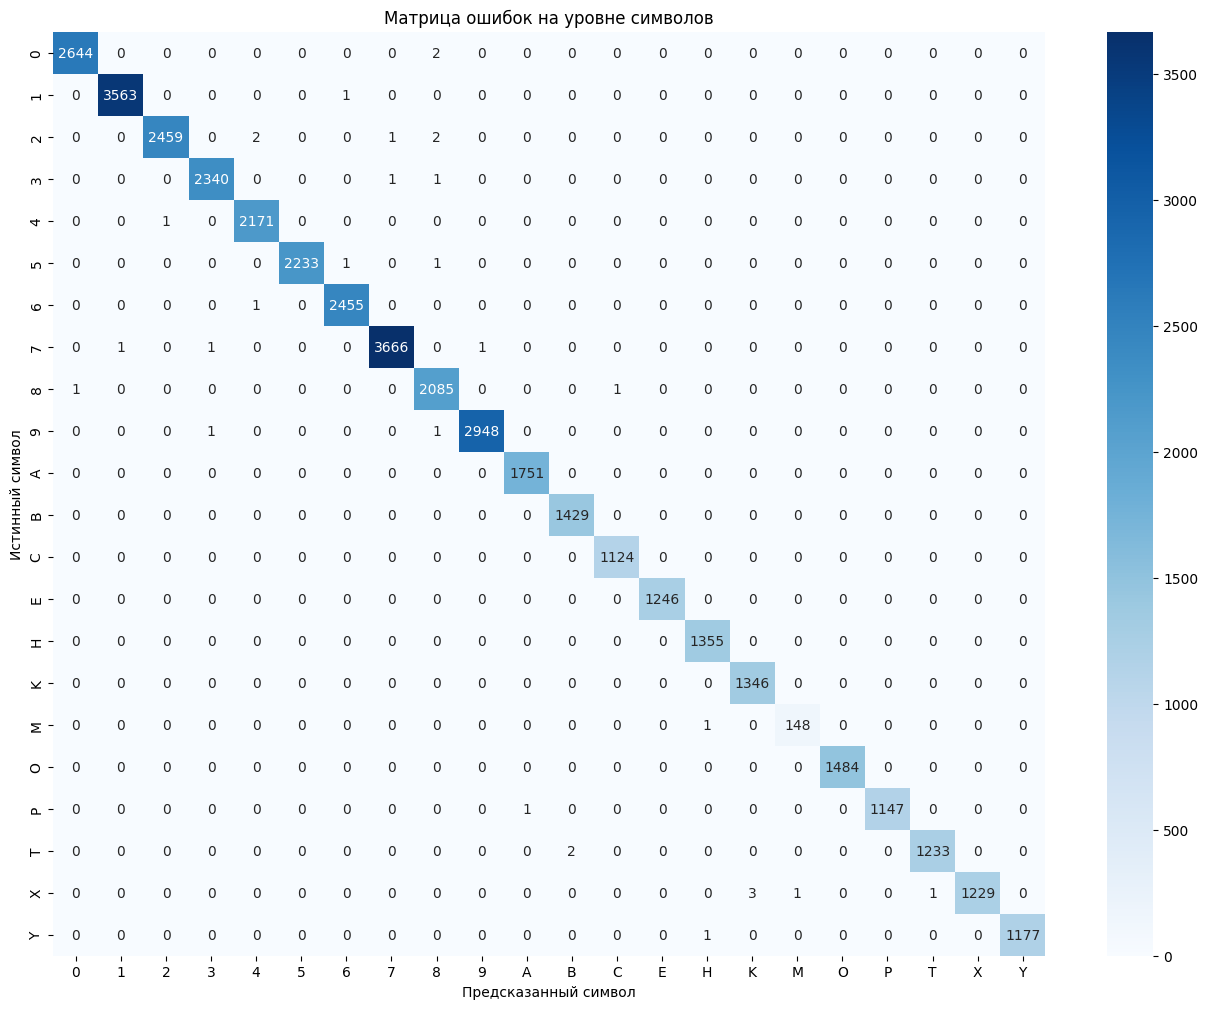


--- 🏆 Финальные метрики лучшей модели ---
Лучшая эпоха: 8
Точность (Exact Match Accuracy): 0.9933
Ошибка по символам (Character Error Rate): 0.0008
------------------------------------------



In [6]:
print("--- 📊 Графики процесса обучения ---")
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Validation Loss')
axes[0].set_title('Кривые ошибок (Loss Curves)')
axes[0].set_xlabel('Эпохи'); axes[0].set_ylabel('Loss'); axes[0].legend(); axes[0].grid(True)
axes[1].plot(history['val_accuracy'], label='Validation Accuracy (Exact Match)')
axes[1].plot(history['val_cer'], label='Validation CER (Character Error Rate)')
axes[1].set_title('Кривые метрик (Metric Curves)'); axes[1].set_xlabel('Эпохи')
axes[1].set_ylabel('Значение'); axes[1].legend(); axes[1].grid(True)
plt.show()

print("\n---  Confusion Matrix (на уровне символов) ---")
model.load_state_dict(torch.load('crnn_ocr_model_best.pth'))
model.eval()
all_true_chars, all_pred_chars = [], []
with torch.no_grad():
    for images, texts, text_lengths in tqdm(val_loader, desc="Сбор данных для матрицы ошибок"):
        images = images.to(device)
        preds = model(images)
        decoded_preds = decode_preds(preds)
        original_texts = ["".join([int_to_char.get(i.item(), '') for i in text if i != 0]) for text in texts]
        for true_str, pred_str in zip(original_texts, decoded_preds):
            for i in range(min(len(true_str), len(pred_str))):
                all_true_chars.append(true_str[i])
                all_pred_chars.append(pred_str[i])

labels = sorted(list(ALPHABET))
cm = confusion_matrix(all_true_chars, all_pred_chars, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(16, 12))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок на уровне символов'); plt.ylabel('Истинный символ'); plt.xlabel('Предсказанный символ')
plt.show()

print("\n--- 🏆 Финальные метрики лучшей модели ---")
best_epoch_idx = np.argmax(history['val_accuracy'])
print(f"Лучшая эпоха: {best_epoch_idx + 1}")
print(f"Точность (Exact Match Accuracy): {history['val_accuracy'][best_epoch_idx]:.4f}")
print(f"Ошибка по символам (Character Error Rate): {history['val_cer'][best_epoch_idx]:.4f}")
print("------------------------------------------\n")

Найдено 2845 изображений в E:/Datasets/numberplate/autoriaNumberplateOcrRu-2021-09-01/test

✅ Тестовый загрузчик данных готов. Найдено 2845 изображений.
🚀 Начинаю финальную оценку на тестовой выборке...


[Final Test]:   0%|          | 0/45 [00:00<?, ?it/s]


--- 🎓 РЕЗУЛЬТАТЫ ФИНАЛЬНОГО ЭКЗАМЕНА ---
Потери на тестовой выборке (Test Loss): 0.0100
Точность (Exact Match Accuracy): 0.9842
Ошибка по символам (Character Error Rate): 0.0022
------------------------------------------

--- 🖼️ Примеры распознавания на тестовых данных ---


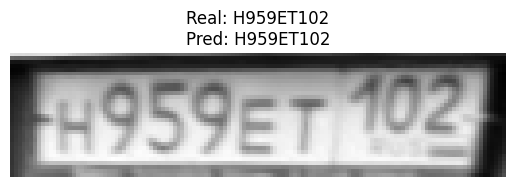

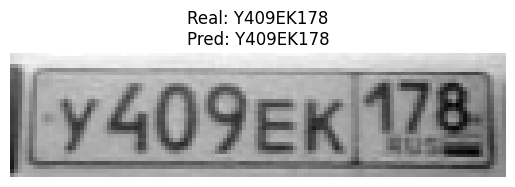

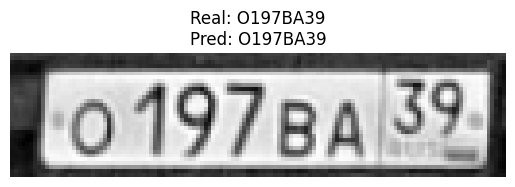

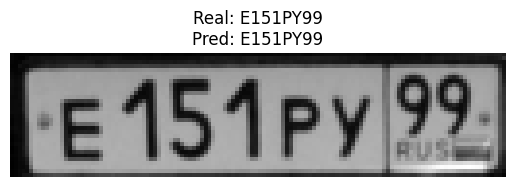

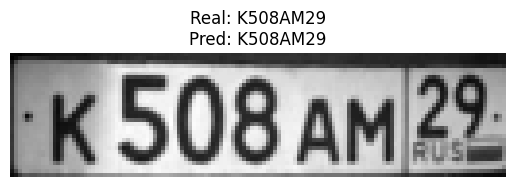

In [7]:
# --- Создаем загрузчик для тестовой выборки ---
TEST_DIR = os.path.join(DATASET_BASE_PATH, 'test')
test_dataset = OCRDataset(TEST_DIR, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)

print(f"\n✅ Тестовый загрузчик данных готов. Найдено {len(test_dataset)} изображений.")

# --- Загружаем нашу лучшую модель ---
model.load_state_dict(torch.load('crnn_ocr_model_best.pth'))
model.to(device)
model.eval()

# --- Проводим оценку на тестовой выборке ---
print("🚀 Начинаю финальную оценку на тестовой выборке...")

test_loss = 0
all_test_decoded_preds = []
all_test_original_texts = []

with torch.no_grad():
    progress_bar_test = tqdm(test_loader, desc="[Final Test]")
    for images, texts, text_lengths in progress_bar_test:
        images, texts, text_lengths = images.to(device), texts.to(device), text_lengths.to(device)
        preds = model(images)
        pred_lengths = torch.full(size=(images.size(0),), fill_value=preds.size(0), dtype=torch.long, device=device)
        
        test_loss += criterion(preds, texts, pred_lengths, text_lengths).item()
        
        decoded_preds = decode_preds(preds)
        original_texts = ["".join([int_to_char.get(i.item(), '') for i in text if i != 0]) for text in texts]
        all_test_decoded_preds.extend(decoded_preds)
        all_test_original_texts.extend(original_texts)

# --- Рассчитываем и выводим финальные метрики ---
avg_test_loss = test_loss / len(test_loader)
test_accuracy = sum(1 for pred, orig in zip(all_test_decoded_preds, all_test_original_texts) if pred == orig) / len(all_test_original_texts)
test_cer = calculate_cer(all_test_decoded_preds, all_test_original_texts)

print("\n--- 🎓 РЕЗУЛЬТАТЫ ФИНАЛЬНОГО ЭКЗАМЕНА ---")
print(f"Потери на тестовой выборке (Test Loss): {avg_test_loss:.4f}")
print(f"Точность (Exact Match Accuracy): {test_accuracy:.4f}")
print(f"Ошибка по символам (Character Error Rate): {test_cer:.4f}")
print("------------------------------------------\n")

# --- Визуализация нескольких примеров из тестовой выборки ---
print("--- 🖼️ Примеры распознавания на тестовых данных ---")
num_examples = 5
for i in range(num_examples):
    # Берем случайный индекс
    idx = random.randint(0, len(all_test_decoded_preds) - 1)
    
    # Находим соответствующее изображение в датасете
    img_obj, _ = test_dataset[idx]
    image = img_obj.permute(1, 2, 0).numpy()
    image = (image * 0.5) + 0.5 
    
    original_text = all_test_original_texts[idx]
    predicted_text = all_test_decoded_preds[idx]
    
    plt.imshow(image, cmap='gray')
    plt.title(f'Real: {original_text}\nPred: {predicted_text}')
    plt.axis('off')
    plt.show()